In [1]:
library(tidyverse)
library(cowplot)
library(data.table)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

 

In [4]:
path_to_master_file <- '../data/sample_stats_22.08.2025_finalMS.tsv'

In [5]:
per_sample_stats_df <-
fread(path_to_master_file)

In [6]:
families <- c('Hominidae', 'Hylobatidae', 'Cercopithecidae', 
              'Callitrichidae', 'Aotidae', 'Cebidae', 'Atelidae', 'Pitheciidae',
             'Tarsiidae',
             'Lemuridae','Indriidae', 'Cheirogaleidae','Lepilemuridae', 'Daubentoniidae', 'Lorisidae', 'Galagidae'
)

In [7]:
references_phylo <- per_sample_stats_df %>%
mutate(family = factor(family, families)) %>%
arrange(family, reference) %>%
select(reference) %>%
distinct() %>%
unlist() %>%
as.vector()

In [8]:
per_sample_stats_df <- per_sample_stats_df %>%
mutate(genus_first_letter = substring(reference, 1, 1)) %>%
mutate(reference_short = sub("_[^_]*$", "", reference)) %>%
mutate(reference_short = sub("^[^_]*_", '', reference_short)) %>%
mutate(reference_short = paste(genus_first_letter, reference_short, sep = '.') ) %>%
mutate(ref_genus_combo = paste0(genus, " (Ref: ", reference_short, ')'))


In [9]:
ref_genus_combo_phylo <- per_sample_stats_df %>%
mutate(family = factor(family, families)) %>%
arrange(family, reference, genus) %>%
select(ref_genus_combo) %>%
distinct() %>%
unlist() %>%
as.vector()

In [10]:
ref_shade <- per_sample_stats_df %>%
select(reference, genus) %>%
distinct() %>%
mutate(reference = factor(reference, references_phylo)) %>%
group_by(reference) %>%
summarise(N = n()) %>%
mutate(cumN = cumsum(N)) %>%
mutate(xmin = cumN - N + 0.5,
      xmax = cumN + 0.5,
      ymin = -Inf,
      ymax = +Inf) 

In [11]:
ref_shade <- ref_shade %>%
filter(row_number() %% 2 != 0)

In [12]:
mask_plot <- per_sample_stats_df %>%
filter(good_sample) %>%
mutate(callability = callable_chrA / len_chrA) %>%
select(ref_genus_combo, reference, genotyping_species, cov_chrA,  callability ) %>%
group_by(ref_genus_combo, reference, genotyping_species) %>%
summarise(callability = mean(callability),
          cumulative_depth = sum(cov_chrA),
         N = n()) %>%
mutate(depth_bin = cut(cumulative_depth, c(10, 20, 30,  50, 100, Inf))) %>%
mutate(ref = sub("_[^_]*$", "", genotyping_species) == sub("_[^_]*$", "", reference)) %>%
mutate(ref_genus_combo = factor(ref_genus_combo, ref_genus_combo_phylo)) %>%
arrange(ref_genus_combo) %>%


ggplot()+
geom_rect(data = ref_shade, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax), fill = 'darkgrey', alpha = 0.2)+
geom_point(aes(x = ref_genus_combo , y = callability, color = ref), alpha = 0.75, shape = 21 , size = 3, stroke = 2)+
geom_point(data = . %>% filter(ref), aes(x = ref_genus_combo, y = callability, color = ref), shape = 21 , size = 3, stroke = 2)+
# scale_color_viridis_d(name = 'cum_depth', option = 6)+
scale_color_manual(values = c('#1e81b0', 'darkorange'))+
# geom_boxplot(aes(x = genus, y = rel_cov_chrX, color = sex), outliers = F)+
ylab('Fraction of the autosomal genome passing the callability mask')+
labs(colour = "reference\nspecies") +
coord_flip()+

# scale_x_log10()+
# xlab('Genus')+


theme_bw() + 
theme(
    text = element_text(size = 16),
    axis.title.y=element_blank()
)

`summarise()` has grouped output by 'ref_genus_combo', 'reference'. You can override using the `.groups` argument.


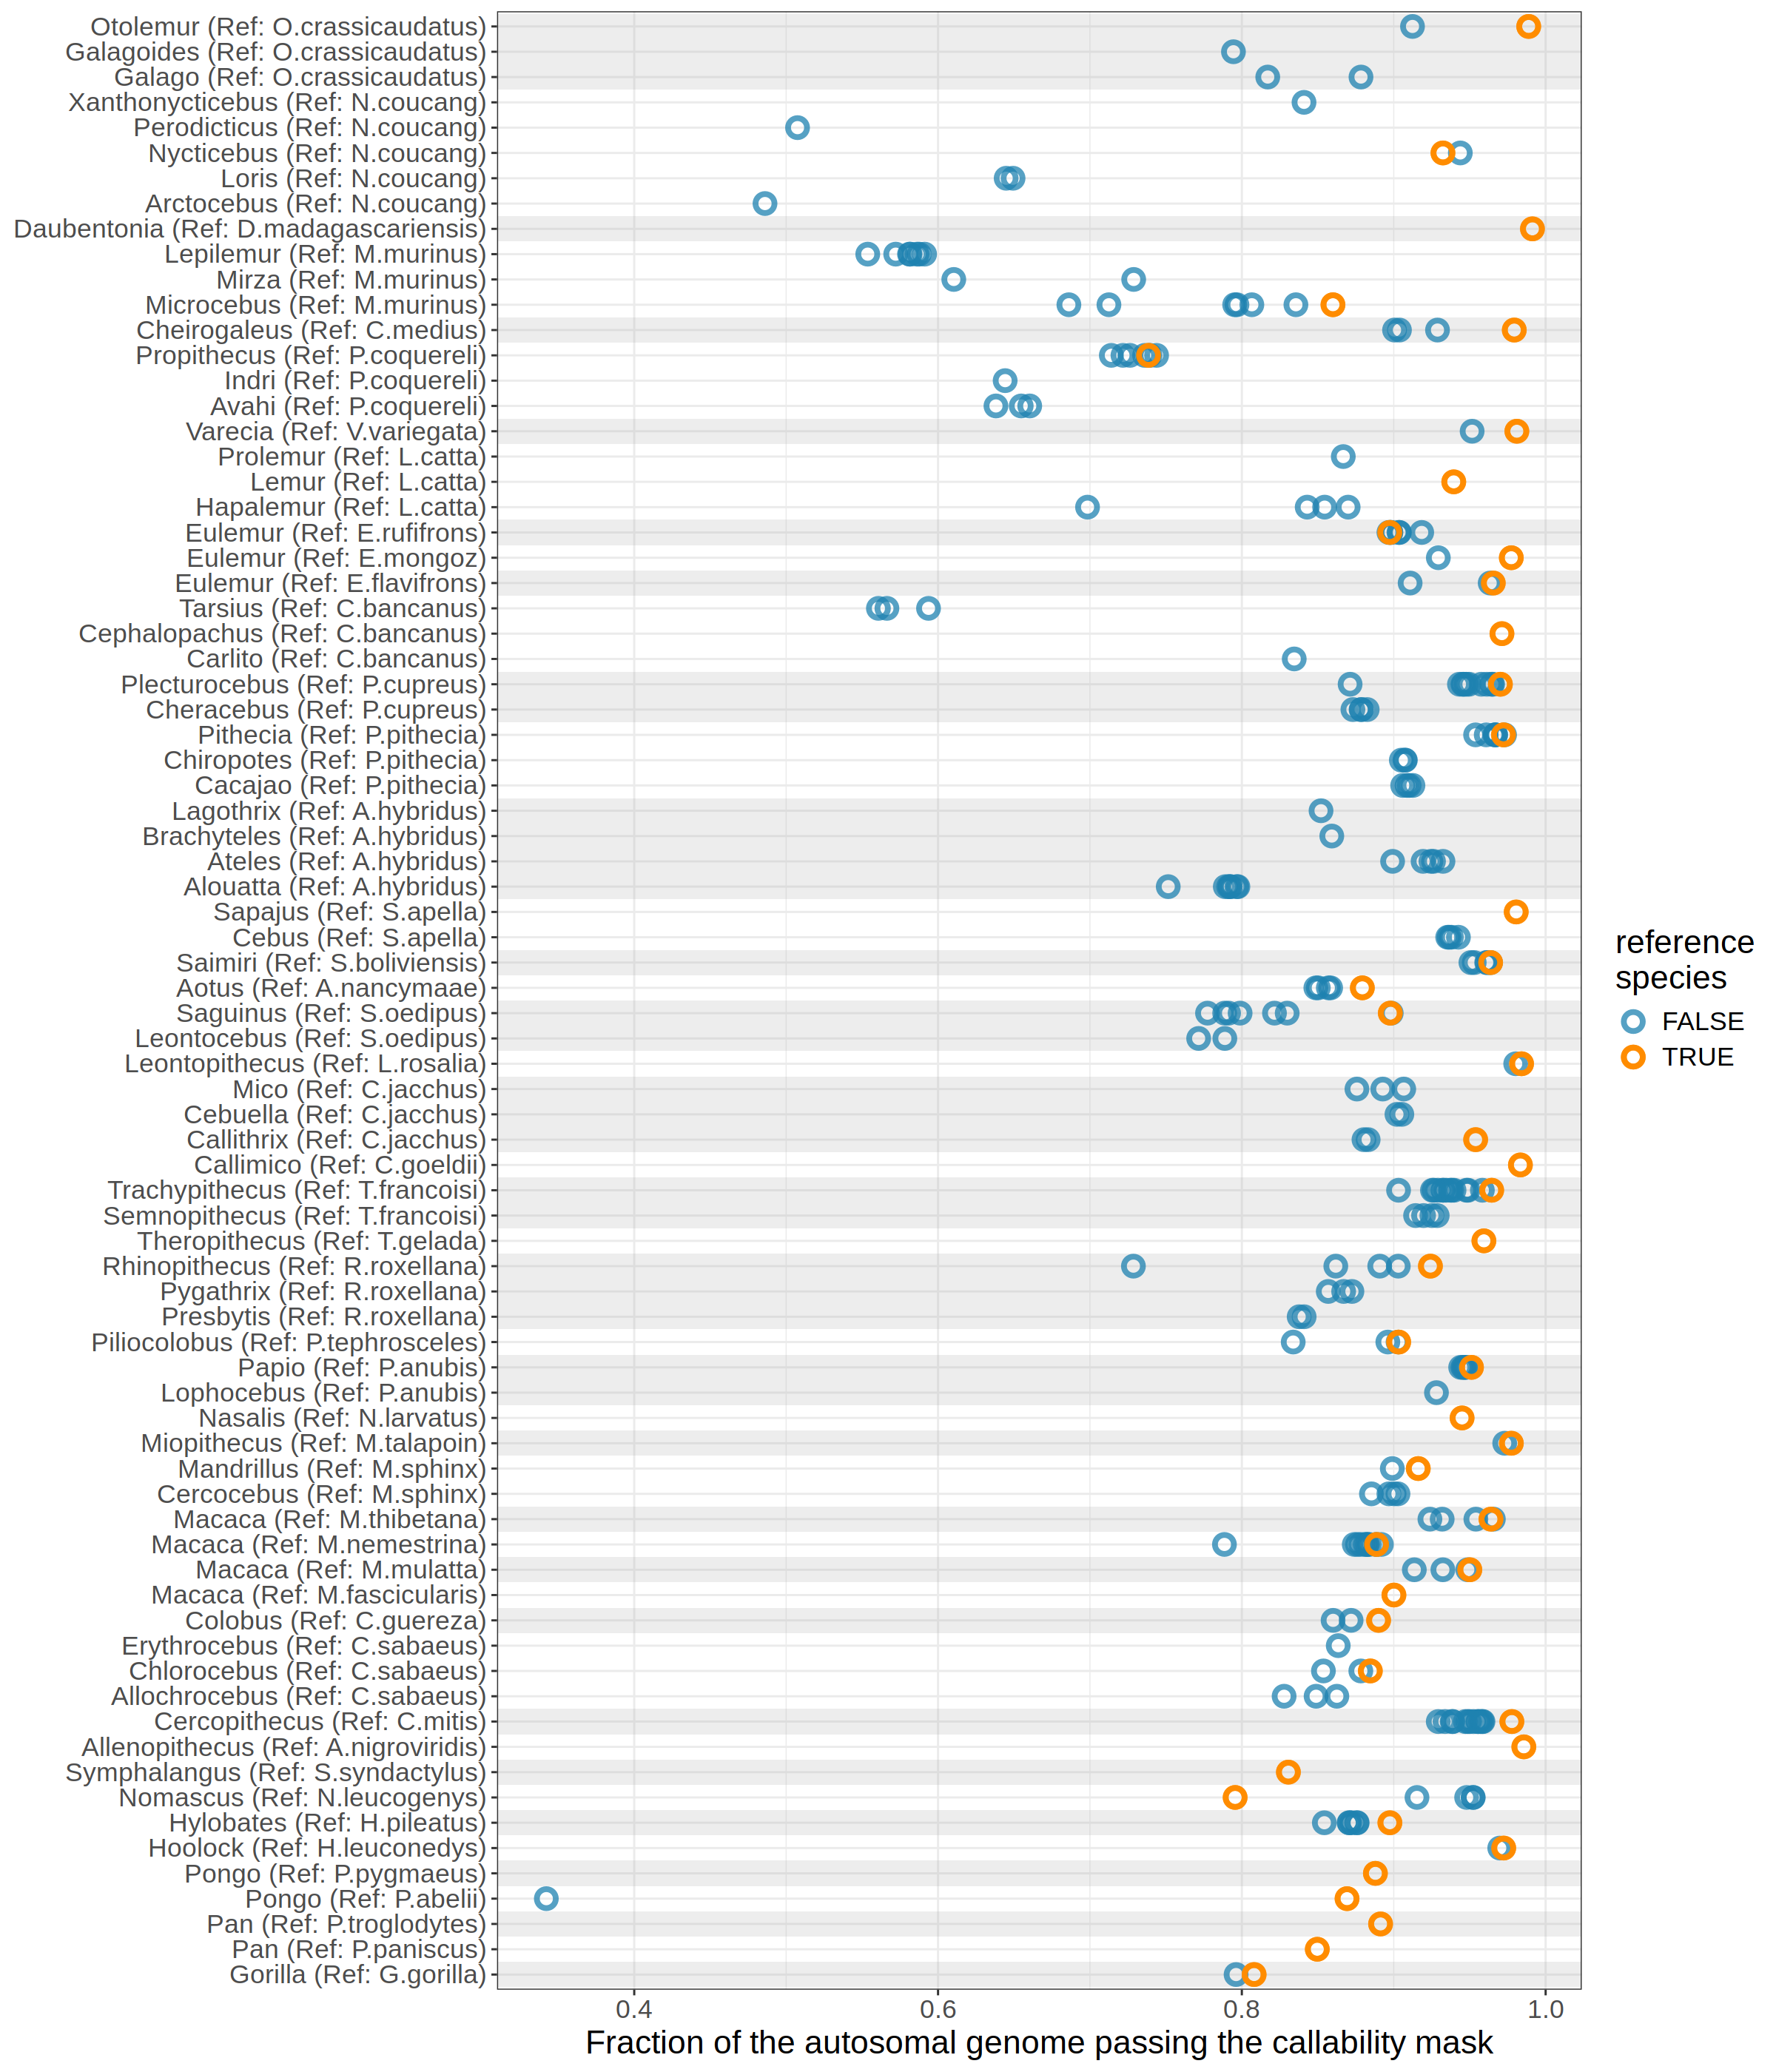

In [13]:
options(repr.plot.width = 12, repr.plot.height = 14, repr.plot.res = 200)

mask_plot

In [14]:
pdf('mask_plot.pdf', width = 12, height = 14)
mask_plot
dev.off()

pdf 
  2